# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    # delete the first row
    df = df.drop(0)
    # set the header and drop the row
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Check for duplicate column names
    duplicate_cols = df.columns[df.columns.duplicated()]
    # print(duplicate_cols) 

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        # Concat
        df_batters = pd.concat([df_batters, df])
        # Move
        shutil.move(file, destination_folder_batters)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [15:32<00:00, 77.71s/it]


In [7]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

## Data Types

### Pitchers

In [8]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [9]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [10]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [11]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [12]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [13]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)

In [14]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [15]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

## Aggregations

### Pitcher aggregations

In [16]:
# # too slow
# wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan
# lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

# %%time
# pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [17]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if item != 'IP':
                ip9_list.append(item)

In [18]:

# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.copy()


df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()

# Reset index
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [19]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

# Reset index
df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['IP'] = df_pitchers_agg_IP

### Batter aggregations

In [20]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO']
wm_def_col = ['PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I', 'FRM', 'ARM']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
#             if (item != 'PA') & ( item != 'IP'):
                wm_col.append(item)


In [21]:
# Aggregation per player and team
df_batters_agg_team = df_batters.copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA'], axis=0).mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP'], axis=0).mul(1000, axis=0)

In [22]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()

# Reset index
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA'], axis=0).mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP'], axis=0).mul(1000, axis=0)


### Team aggregations

In [23]:
# aggergating data for weighted average
df_batters['AVG_C'] = (np.where(df_batters['POS'] == 'C', df_batters['C'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_C'] = np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['1B'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_1B'] = np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['2B'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_2B'] = np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['3B'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_3B'] = np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['SS'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_SS'] = np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['LF'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_LF'] = np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['CF'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_CF'] = np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['PA'], 0).astype(int)
df_batters['AVG_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['RF'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['PA'], 0)).astype(int)
df_batters['PA_RF'] = np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['PA'], 0).astype(int)

In [24]:
# aggregation
df_team_agg_temp = df_batters.groupby('ORG')[['H','HR', 'R', 'BB','SB','AVG_C', 'PA_C','AVG_1B', 'PA_1B','AVG_2B', 'PA_2B','AVG_3B', 'PA_3B','AVG_SS', 'PA_SS','AVG_LF', 'PA_LF','AVG_CF', 'PA_CF','AVG_RF', 'PA_RF','PA','BABIP','GAP','POW','EYE',"K's"]].sum().reset_index()

In [25]:
# w. averages
df_team_agg_temp['AVG_C'] = df_team_agg_temp['AVG_C']/df_team_agg_temp['PA_C']
df_team_agg_temp['AVG_1B'] = df_team_agg_temp['AVG_1B']/df_team_agg_temp['PA_1B']
df_team_agg_temp['AVG_2B'] = df_team_agg_temp['AVG_2B']/df_team_agg_temp['PA_2B']
df_team_agg_temp['AVG_3B'] = df_team_agg_temp['AVG_3B']/df_team_agg_temp['PA_3B']
df_team_agg_temp['AVG_SS'] = df_team_agg_temp['AVG_SS']/df_team_agg_temp['PA_SS']
df_team_agg_temp['AVG_LF'] = df_team_agg_temp['AVG_LF']/df_team_agg_temp['PA_LF']
df_team_agg_temp['AVG_CF'] = df_team_agg_temp['AVG_CF']/df_team_agg_temp['PA_CF']
df_team_agg_temp['AVG_RF'] = df_team_agg_temp['AVG_RF']/df_team_agg_temp['PA_RF']


df_team_agg_temp['AVG_BABIP'] = df_team_agg_temp['BABIP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_GAP'] = df_team_agg_temp['GAP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_POW'] = df_team_agg_temp['POW']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_EYE'] = df_team_agg_temp['EYE']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_KS'] = df_team_agg_temp["K's"]/df_team_agg_temp['PA']

In [26]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['W','L','HR','R', 'ER', 'BB', 'K']].sum().copy()

# Rename columns
df_team_agg = df_team_agg.rename(columns={'HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA'})

# Merge with batters' data by team
df_team_agg = df_team_agg.merge(df_team_agg_temp, on='ORG', how='left')

# Adding averages per game
for metric in df_team_agg.iloc[:,1:13].columns:
    name = 'AVG_'+metric
    df_team_agg[name] = df_team_agg[metric] / (df_team_agg['W'] + df_team_agg['L'])
    df_team_agg[name] = df_team_agg[name]
    
    # Handling missings 
    df_team_agg[name].fillna(0, inplace=True)
    df_team_agg[name].replace({None: 0}, inplace=True)

# Filter teams with more than X wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 40].sort_values('AVG_W', ascending=False)

,ORG,W,L,HRA,RA,ERA,BBA,K,H,HR,R,BB,SB,AVG_C,PA_C,AVG_1B,PA_1B,AVG_2B,PA_2B,AVG_3B,PA_3B,AVG_SS,PA_SS,AVG_LF,PA_LF,AVG_CF,PA_CF,AVG_RF,PA_RF,PA,BABIP,GAP,POW,EYE,K's,AVG_BABIP,AVG_GAP,AVG_POW,AVG_EYE,AVG_KS,AVG_W,AVG_L,AVG_HRA,AVG_RA,AVG_ERA,AVG_BBA,AVG_K,AVG_H,AVG_HR,AVG_R,AVG_BB,AVG_SB
616,Tippecanoe Terrors,60,31,107,388,368,355,701,880,62,494,419,58,99.349010,404.0,78.251485,505.0,82.504098,488.0,53.574468,705.0,95.000000,342.0,81.680851,470.0,98.196172,418.0,77.000000,327.0,3659,4415,4285,3520,4930,4080,1.206614,1.171085,0.962011,1.347363,1.115059,0.659341,0.340659,1.175824,4.263736,4.043956,3.901099,7.703297,9.67033,0.681319,5.428571,4.604396,0.637363
8,Adidas Nylon Pants,65,34,103,388,371,396,795,896,142,542,501,61,84.965854,410.0,NaN,0.0,72.368421,494.0,79.615063,478.0,75.854460,426.0,78.112605,595.0,68.035111,1538.0,NaN,0.0,3941,5026,5601,6097,7719,4853,1.275311,1.421213,1.547069,1.95864,1.231413,0.656566,0.343434,1.040404,3.919192,3.747475,4.0,8.030303,9.050505,1.434343,5.474747,5.060606,0.616162
204,Felix Antkillers,51,29,87,315,300,308,648,679,112,412,394,44,96.783439,314.0,78.341085,387.0,71.455026,567.0,49.289544,373.0,95.000000,284.0,76.290076,393.0,57.502494,802.0,NaN,0.0,3120,5548,5751,6289,7514,4663,1.778205,1.843269,2.015705,2.408333,1.494551,0.6375,0.3625,1.0875,3.9375,3.75,3.85,8.1,8.4875,1.4,5.15,4.925,0.55
177,Ditmas Park Tip-Tops,55,32,76,395,379,380,729,841,117,510,449,103,96.532982,379.0,72.867925,212.0,74.636488,729.0,62.256711,596.0,82.462162,370.0,72.107807,269.0,55.620390,922.0,91.000000,30.0,3507,4144,4345,3777,5089,3733,1.181637,1.238951,1.076989,1.451098,1.064443,0.632184,0.367816,0.873563,4.54023,4.356322,4.367816,8.37931,9.666667,1.344828,5.862069,5.16092,1.183908
641,Vancouver Vibes TBD,77,46,129,473,441,499,932,1124,115,639,589,88,99.276316,532.0,81.657576,660.0,73.641124,783.0,46.000000,454.0,91.000000,429.0,82.292308,585.0,83.639196,995.0,70.154897,439.0,4877,7988,8280,7542,10514,7144,1.637892,1.697765,1.546442,2.155834,1.464835,0.626016,0.373984,1.04878,3.845528,3.585366,4.056911,7.577236,9.138211,0.934959,5.195122,4.788618,0.715447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Colleyville Crushers,51,50,133,451,427,473,797,860,130,465,508,2,80.952484,463.0,79.615217,920.0,72.389163,609.0,74.181319,364.0,78.475758,660.0,75.341232,422.0,70.127159,637.0,71.692308,143.0,4218,8915,9847,11469,13762,8293,2.113561,2.334519,2.719061,3.262684,1.966098,0.50495,0.49505,1.316832,4.465347,4.227723,4.683168,7.891089,8.514851,1.287129,4.60396,5.029703,0.019802
334,Llanelli Scarlets,45,45,102,410,394,448,658,779,69,408,387,146,81.105012,419.0,81.530100,598.0,87.651042,384.0,68.520782,409.0,82.000000,321.0,87.984887,397.0,94.895954,346.0,82.096360,467.0,3341,8861,9239,6204,11463,7280,2.6522,2.76534,1.856929,3.431009,2.178988,0.5,0.5,1.133333,4.555556,4.377778,4.977778,7.311111,8.655556,0.766667,4.533333,4.3,1.622222
2,1st Class Millionaires,43,43,140,405,396,513,765,772,71,396,399,72,60.974227,388.0,78.116625,403.0,73.000000,381.0,70.675325,385.0,86.705015,339.0,59.426307,631.0,103.830721,319.0,77.219512,492.0,3338,8914,9682,6519,10464,7949,2.670461,2.900539,1.952966,3.134811,2.381366,0.5,0.5,1.627907,4.709302,4.604651,5.965116,8.895349,8.976744,0.825581,4.604651,4.639535,0.837209
51,Banff Grizzlies,67,71,159,719,682,585,1057,1207,176,674,640,50,77.211921,604.0,71.235919,941.0,71.772554,787.0,46.197471,1028.0,73.000000,499.0,67.376972,634.0,52.000000,543.0,77.000000,355.0,5391,11943,12067,13948,16831,11039,2.215359,2.23836,2.587275,3.122055,2.047672,0.485507,0.514493,1.152174,5.210145,4.942029,4.23913,7.65942,8.746377,1.275362,4.884058,4.637681,0.362319


In [27]:
# fillnas
df_team_agg['AVG_C'].fillna(50, inplace=True)
df_team_agg['AVG_1B'].fillna(50, inplace=True)
df_team_agg['AVG_2B'].fillna(50, inplace=True)
df_team_agg['AVG_3B'].fillna(50, inplace=True)
df_team_agg['AVG_SS'].fillna(50, inplace=True)
df_team_agg['AVG_LF'].fillna(50, inplace=True)
df_team_agg['AVG_CF'].fillna(50, inplace=True)
df_team_agg['AVG_RF'].fillna(50, inplace=True)

df_team_agg['AVG_C'].replace({None: 50}, inplace=True)
df_team_agg['AVG_1B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_2B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_3B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_SS'].replace({None: 50}, inplace=True)
df_team_agg['AVG_LF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_CF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_RF'].replace({None: 50}, inplace=True)



df_team_agg['AVG_BABIP'].fillna(50, inplace=True)
df_team_agg['AVG_GAP'].fillna(50, inplace=True)
df_team_agg['AVG_POW'].fillna(50, inplace=True)
df_team_agg['AVG_EYE'].fillna(50, inplace=True)
df_team_agg['AVG_KS'].fillna(50, inplace=True)

df_team_agg['AVG_BABIP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_GAP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_POW'].replace({None: 50}, inplace=True)
df_team_agg['AVG_EYE'].replace({None: 50}, inplace=True)
df_team_agg['AVG_KS'].replace({None: 50}, inplace=True)

# Analysis

## My team comparison

### Batting

In [28]:
df_batters_agg_team[df_batters_agg_team['ORG'] == 'Fogtown Stars'].sort_values('WAR', ascending=False)

,POS,Name,ORG,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
5612,CF,Gorman Thomas,Fogtown Stars,TRN,"6' 2""",Right,Right,61,47,59,62,109,90,31,48,64,66,117,91,33,47,58,60,107,90,30,27,7,Flyball,Ex. Pull,Normal,0,0,10,3,10,8,71,63,51,52,0,0,0,0,0,0,0,52,0,34,55,68,241.98895,116.022099,11.3125,493.922652,159.116022,72.928177,21.546961,0.0,64.640884,145.856354,135.911602,106.077348,15.625,0.0,0.0,0.0,0.0,0.0,134.254144,21.871875,21.546961,86.187845,374.585635,0.3315,0.437281,0.80175,3.14375,14.121875,0.470219,0.513406,1.239187,245.0625,0.314844,9.58011,119.337017,249.40625,87.016575,11.933702,4.467812,0.0,0.0,0.0,87.016575,0.0,10.607735,10.607735,62.983425,0.0,39.779006,0.0,39.779006,0.0,0.0,0.0,0.375,1.6875,-0.1875,0.252375,0.0,0.0,0.0,2.15625,0.0,0.0,0.0,37.5,265.010352,265.010352,37.5,265.010352,265.010352,0.0,265.010352,0.0,0.0,0.0,0.0,0.0,265.010352,0.0,0.0,0.0,53.00207,100.0,32,7.0
6508,LF,Brad Wilkerson,Fogtown Stars,TRN,"6' 0""",Left,Left,67,83,69,69,62,89,36,83,68,70,60,84,35,83,69,69,62,91,36,24,2,Groundball,Ex. Pull,Normal,0,0,34,33,34,36,71,51,95,90,0,0,52,0,0,0,90,56,0,57,56,45,133.904253,131.312578,57.52037,510.817424,147.181353,93.280963,27.690673,8.898619,17.311098,80.63166,89.430476,80.853804,13.268858,0.833843,3.873024,0.0,4.188532,0.267216,147.245742,24.380617,10.653231,53.90039,244.602556,0.279277,0.379036,0.459469,9.63963,7.174228,0.180182,0.376582,0.838536,120.857099,0.359173,3.323653,90.431731,123.600617,22.211133,4.033998,4.237784,3.299958,4.365603,19.687191,22.211133,-0.638743,1.082708,0.470687,135.278967,131.312578,330.565661,7.456296,317.546119,5.563247,1.699881,0.0,0.981602,2.506185,0.200741,1.010609,0.0,0.0,0.0,110.094167,0.0,0.0,0.0,96.257315,225.888633,217.066562,68.125401,37.365771,27.908864,35.817932,33.022609,13.231441,27.233056,27.344147,8.260542,20.854938,30.460521,6.776313,47.167043,0.0,2.033184,90.33858,3240,6269.7
1534,2B,Dink Mothell,Fogtown Stars,TRN,"6' 0""",Switch,Right,69,75,71,89,43,101,55,76,71,90,44,102,55,75,71,89,43,101,55,96,100,Line Drive,Spray,Pull,61,60,67,68,62,71,74,61,66,73,120,57,80,73,61,0,89,59,77,69,80,74,138.76199,120.500678,59.572872,500.732729,146.413865,93.45388,37.863337,4.07664,11.020008,62.602945,89.420841,94.994429,14.7829,1.119078,1.740384,0.908342,1.624116,0.0,109.79314,18.041847,9.715628,52.959984,225.490505,0.293312,0.397754,0.440093,9.885823,7.572114,0.146755,0.37915,0.83775,121.447691,0.354516,3.77656,91.539095,124.801587,22.82991,4.029043,4.466093,10.874673,7.80811,44.910137,22.82991,0.02616,-0.613676,-0.463255,154.396376,120.500678,456.619998,267.575816,183.125424,5.918758,71.021461,0.0,0.984779,3.664747,-0.372619,0.975791,0.719407,0.210735,2.092352,112.040476,0.0,1.510491,0.028943,89.377561,166.794164,149.034631,56.468038,41.532304,25.090108,37.852165,36.466949,15.649971,24.266883,37.192954,11.462496,15.917136,31.963856,6.300649,41.768286,-0.05301,0.22236,94.628066,2772,5189.2
8203,RF,Kirk Gibson,Fogtown Stars,TRN,"6' 3""",Left,Left,69,47,61,57,90,70,46,47,55,52,82,64,42,47,63,59,92,72,47,13,5,Flyball,Normal,Normal,0,0,2,1,10,9,74,60,55,72,0,0,0,0,0,0,0,57,72,60,55,74,162.133556,135.244874,44.883753,515.332769,138.065279,90.020495,15.301159,1.755871,30.987754,94.462175,95.661307,74.327783,11.895927,0.0,3.872704,0.0,6.289321,0.177422,116.19337,20.49849,5.995656,48.044784,249.841441,0.257519,0.346209,0.467553,7.322014,7.211625,0.210083,0.361565,0.813872,113.487414,0.

### Catching

In [29]:
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['POS'] == 'C')][['Name','C ABI','C ARM','CERA']].sort_values('CERA', ascending=True)

,Name,C ABI,C ARM,CERA
4357,Ernie Whitt,67,57,4.221174
3924,Bruce Petway,92,80,4.427047
4809,Ozzie Virgil,66,53,4.465149


### Pitching

#### Starters

In [30]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
5417,SP,Alex Wood,Fogtown Stars,Right,Left,66,74,58,72,49,61,86,69,76,57,73,70,55,71,46,57,0,0,0,77,74,0,0,0,63,0,0,0,3,NEU,92,3/4,Normal,70,76,40,41,44,86,1.64225,1.64225,0.529758,0.494441,0.520817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,509.666667,39.36102,35.122956,9.959451,6.551341,1.783519,0.158927,1.465664,16.457816,5.456508,5.209287,3.514061,0.0,8.122956,0.24722,3.49446,0.278417,0.345601,0.459493,0.80501,0.323533,1.496841,2.65605,20.65036,8.849052,11.808698,0.211903,0.24722,0.282538,0.017659,0.017659,0.88293,0.0,0.0,0.0,0.0,0.0,73.0,0.996259,0.0,0.63571,0.433763,0.0,0.0,0.0,97.699804,14.843035,3.672335,378.366906,19.328319,22.360366,0.469326,1.261609,0.891432,4.58826,100.590582,-0.107717,0.12361,0.082995,3.972852,0.75932,0.529758,0.12361,0.105952,0.017659,0.0,0.669812,0.653074,-0.077632,0.542889
8015,SP,Lloyd Brown,Fogtown Stars,Left,Left,68,56,104,56,54,105,54,99,55,52,102,57,105,56,55,106,64,56,69,0,0,0,0,0,0,0,0,0,3,GB,90,OTT,GB'er,84,60,28,27,28,64,1.61194,1.61194,0.345416,0.690832,0.369953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.333333,40.643923,34.714286,10.132196,6.620469,2.245203,0.115139,1.151386,16.061834,6.275053,6.102345,5.123667,0.0,6.908316,0.287846,3.884776,0.290998,0.383849,0.461318,0.844778,0.332418,1.695267,1.416418,17.100853,12.554584,4.510874,0.230277,0.287846,0.115139,0.0,0.0,1.093817,0.0,0.0,0.0,0.0,0.0,66.506397,1.070959,0.0,0.575693,0.366273,0.0,0.0,0.0,101.313433,11.616205,3.157143,374.055437,19.518124,20.812367,0.475309,1.134328,2.061834,4.903774,108.358209,-0.201493,0.07484,-0.023028,4.890341,0.863539,0.690832,0.115139,0.057569,0.0,0.0,0.676972,0.804009,0.26951,0.740917
6954,SP,Jimmy Key,Fogtown Stars,Right,Left,65,49,71,79,89,64,50,73,73,90,65,49,71,80,88,64,49,35,61,39,0,0,0,0,0,0,0,0,4,NEU,90,3/4,Finesse,84,79,29,26,28,64,1.457039,1.457039,0.610491,0.333735,0.653133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1105.666667,37.541152,34.07356,8.49804,5.69792,1.579138,0.105819,1.115164,13.634308,4.167621,3.890865,2.881519,0.0,5.470003,0.195357,4.234938,0.243923,0.302654,0.391071,0.693751,0.259757,1.264172,2.169792,14.751673,7.537685,7.215225,0.073259,0.309316,0.211637,0.02442,0.00814,0.854688,0.0,0.0,0.0,0.0,0.0,76.205909,0.99495,0.0,0.895387,0.669569,0.065119,0.052082,0.01628,101.854085,12.596623,3.912059,324.356949,20.941815,23.657522,0.470826,0.883328,0.83057,4.430609,97.436841,0.005698,0.142448,0.218149,4.682985,0.944227,0.626771,0.268616,0.048839,0.01628,0.0,0.75104,0.895327,0.050859,0.625615
7151,SP,Johnny Antonelli,Fogtown Stars,Left,Left,69,86,68,51,67,67,85,68,51,66,66,86,69,51,67,67,80,0,87,49,0,0,0,0,0,69,0,0,4,NEU,92,3/4,Normal,74,77,29,24,26,62,1.554864,1.554864,0.640856,0.367704,0.567595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,856.666667,38.493385,33.566148,8.247082,5.210895,1.733463,0.189105,1.113619,13.699611,4.191829,4.044747,4.475486,0.0,9.140078,0.168093,4.287747,0.240122,0.328728,0.399247,0.728063,0.297815,1.412747,2.473268,23.920117,11.363268,12.550195,0.136576,0.147082,0.336187,0.021012,0.0,0.829961,0.0,0.0,0.0,0.0,0.0,79.225058,1.047778,0.0,0.798444,0.563446,0.010506,0.007603,0.0,102.971984,11.671984,3.52751,302.827237,13.916732,17.415953,0.448984,0.896498,0.91751,4.139502,90.8393,0.001051,0.17965,0.214319,3.801237,0.956031,0.651362,0.231128,0.073541,0.031518,0.0,0.632677,0.88228,0.03,0.510028
7536,SP,Jumbo Elliott,Fogtown Stars,Right,Left,69,76,74,61,64,73,74,73,61,63,71,76,75,61,65,74,73,71,84,0,0,0,0,0,0,0,0,0,3,FB,90,3/4,Normal,76,55,20,19,19,43,1.611226,1.611226,0.518464,0.534417,0.514442,

#### Relievers

In [31]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'].isin(['RP','CL']))].sort_values('ERA', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
1098,RP,Alex Cobb,Fogtown Stars,Right,Right,69,62,86,58,63,86,60,84,58,61,83,63,89,59,65,88,47,0,55,0,72,66,0,0,0,0,0,0,4,GB,91,Normal (3/4),GB'er,64,55,35,25,30,71,7.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.928571,0.0,0.0,4.666667,36.642857,30.857143,3.857143,1.928571,1.928571,0.0,0.0,5.785714,0.0,0.0,5.785714,0.0,9.642857,0.0,0.0,0.120929,0.2525,0.180214,0.432714,0.175,1.071429,0.964286,26.892857,13.928571,12.964286,0.0,0.0,0.0,0.0,0.0,0.0,7.714286,3.857143,0.0,0.0,0.0,100.0,0.467143,0.392857,0.0,0.0,0.0,0.0,0.0,17.214286,0.0,0.0,20.428571,1.785714,1.428571,0.560714,0.0,0.0,2.264286,54.571429,0.192857,0.385714,0.578571,3.9,1.928571,1.928571,0.0,0.0,0.0,0.0,0.357143,1.928571,0.035714,0.358214
1418,RP,Bob Walk,Fogtown Stars,Right,Right,69,35,107,57,81,102,32,98,55,77,98,37,115,58,85,106,0,14,39,32,63,0,0,0,0,0,0,0,4,GB,90,Normal (3/4),GB'er,74,55,28,22,26,59,4.05,0.0,2.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,6.666667,37.8,33.75,6.75,6.75,0.0,0.0,0.0,6.75,0.0,0.0,4.05,0.0,4.05,0.0,0.0,0.2,0.27905,0.2,0.47905,0.22785,1.1965,1.475,11.03,9.875,1.125,0.0,0.0,1.35,0.0,0.0,0.0,4.05,0.0,4.05,0.0,0.0,100.0,0.539,0.0,0.0,0.0,0.0,0.0,0.0,33.7,0.0,0.0,50.6,5.6,3.0,0.63,0.0,0.65,3.0535,73.35,0.27,0.135,0.54,5.6175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195,0.0
3152,RP,Jon Garland,Fogtown Stars,Right,Right,69,47,76,83,77,72,47,76,83,76,71,47,77,83,78,73,0,35,47,30,61,38,39,0,0,0,0,0,6,NEU,90,Over the Top,Finesse,65,105,39,30,37,80,2.842105,0.0,0.0,0.0,0.0,2.842105,1.421053,0.473684,0.0,0.0,0.0,1.421053,0.0,6.333333,32.684211,27.0,1.421053,1.421053,0.0,0.0,0.0,1.421053,0.0,0.0,5.684211,0.0,8.526316,0.0,0.0,0.047895,0.216316,0.047895,0.264211,0.065789,0.791053,1.5,26.368421,17.578947,8.789474,0.0,0.0,0.0,0.0,0.0,1.421053,2.842105,1.421053,2.842105,0.0,0.0,100.0,0.526842,0.473684,0.0,0.0,0.0,0.0,0.0,48.736842,0.0,0.0,48.736842,3.526316,2.526316,0.584211,0.0,0.0,2.563684,61.684211,0.142105,0.284211,0.568421,4.267895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105263,0.0
3441,RP,Kevin Slowey,Fogtown Stars,Right,Right,69,59,47,98,57,48,57,46,97,55,47,60,48,99,58,49,46,67,43,44,61,0,0,0,0,0,0,0,5,EX FB,90,Over the Top,Finesse,63,70,27,27,25,61,4.5,0.0,0.5,0.0,0.425926,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.000000,32.5,31.5,5.0,2.5,1.0,0.0,1.5,10.5,2.5,2.5,1.0,0.0,6.5,0.0,3.9,0.157019,0.182333,0.329796,0.51213,0.146574,0.665741,2.037037,20.081481,3.025926,17.055556,0.0,0.0,0.5,0.0,0.0,0.0,4.5,1.5,1.5,0.0,0.0,78.703704,0.473704,0.316463,0.0,0.0,0.0,0.0,0.0,27.574074,0.0,0.0,83.611111,5.314815,8.611111,0.397963,0.0,0.259259,3.54463,89.648148,0.25,0.1,0.2,3.152037,0.5,0.0,0.5,0.0,0.0,0.0,0.314815,0.500556,0.077778,0.0
3865,RP,Melido Perez,Fogtown Stars,Right,Right,69,83,73,48,61,73,79,70,47,59,70,87,77,49,64,77,81,0,0,69,0,0,0,78,0,0,0,0,3,NEU,92,Over the Top,Normal,83,58,27,21,23,55,9.0,0.0,1.125,1.125,0.25,7.875,6.75,0.875,1.125,0.125,0.0,5.625,1.125,8.000000,33.75,29.25,4.5,3.375,0.0,0.0,1.125,7.875,2.25,2.25,4.5,0.0,12.375,0.0,5.0625,0.1395,0.2585,0.255,0.513,0.2,1.0,2.75,35.85,13.6,22.2,0.0,0.0,0.0,0.0,0.0,2.25,9.0,9.0,0.0,0.0,0.0,88.45,1.6075,1.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,54.75,1.5,2.25,0.395,0.0,0.0,2.86,70.25,0.0,0.1125,0.225,2.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3059,RP,Johnny Markham,Fogtown Stars,Right,Right,69,66,73,76,77,69,59,66,73,70,63,71,79,78,83,73,69,0,0,75,0,0,0,0,0,0,0,0,2,NEU,92,OTT,Normal,22,85,24,20,21,50,7.109043,0.0,0.885638,0.406915,0.472406,0.933511,0.263298,0.119846,0.670213,0.315438,1.962766,2.992021,1.460106,3

## Player analytics

In [32]:
df_batters_agg[(df_batters_agg['PA_WM'] > 600) & (df_batters_agg['POS'] == 'RF')].sort_values('WAR', ascending=False).head(10)

,POS,Name,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
688,RF,Reggie Sanders,TRN,"6' 1""",Right,Right,68,62,66,65,74,76,45,62,67,67,75,81,46,62,65,64,73,75,45,5,6,Flyball,Pull,Normal,0,0,1,8,4,6,66,58,41,57,0,0,0,0,0,0,72,42,57,88,82,65,152.735002,129.110838,44.352126,527.56465,147.021192,88.701577,25.580862,4.544792,28.193961,89.533018,97.097251,63.833378,10.435397,1.969201,2.83815,0.0,5.620038,0.143783,123.422034,20.46719,7.451708,58.319615,266.273521,0.269852,0.347187,0.475915,7.417791,7.008457,0.206037,0.363258,0.823208,114.715342,0.305339,3.421097,84.925712,113.948244,17.778449,3.305758,3.981511,17.266457,13.378066,41.293207,17.778449,-1.528475,5.334973,3.783367,141.669966,124.272229,331.932318,8.395674,316.566296,6.970347,2.150493,0.0,0.966107,2.641414,-0.02232,0.984531,0.0,0.0,0.0,82.515065,0.0,0.0,0.0,95.513771,245.376521,236.427001,61.209473,44.085163,32.459852,25.320379,28.961248,11.612146,18.979898,26.599923,6.43201,16.323752,26.576884,5.584661,58.332108,0.0,-0.668484,90.127542,2164,4050.4
658,RF,Joey Gallo,TRN,"6' 5""",Left,Right,68,28,48,43,111,94,38,27,45,42,98,88,37,29,49,44,115,96,38,27,67,Flyball,Ex. Pull,Pull,0,0,30,42,81,28,60,60,99,77,0,0,72,0,0,0,79,40,77,33,72,57,139.634396,137.912944,17.452074,503.795393,117.648988,62.070662,16.034101,0.0,39.544225,96.155423,86.170998,87.695713,15.018598,0.0,1.426346,0.0,7.082548,0.0,145.782441,24.021888,12.394459,55.578326,252.315764,0.217153,0.340462,0.460041,2.844063,6.741917,0.243021,0.363695,0.800554,112.79113,0.221351,1.155341,73.776539,115.746781,16.457087,2.842856,4.288598,2.410034,0.688581,7.010014,16.457087,0.37872,0.068858,0.447578,128.96139,127.584228,339.913108,8.853185,328.403968,2.655955,6.148045,0.0,0.951479,2.637983,0.012876,0.957286,0.0,0.0,0.0,32.549642,0.0,0.0,0.0,89.622175,231.119397,219.132571,57.510014,48.688685,36.424707,26.085122,37.625699,16.70072,18.072389,21.276038,8.039719,12.374821,29.775368,7.090473,60.312903,0.0,-1.536115,99.284692,699,1330.2
683,RF,Pat Mullin,TRN,"6' 2""",Left,Right,65,49,53,86,71,79,42,48,49,79,65,75,40,49,54,89,73,81,43,26,7,Flyball,Normal,Normal,0,0,10,9,6,1,78,86,72,88,0,0,0,0,0,0,0,0,88,79,60,60,153.287142,138.920174,47.849303,504.079196,124.637817,63.830627,36.630973,2.05323,22.122987,92.350215,80.673881,84.644962,12.720153,0.310241,3.621356,0.507667,7.062208,0.084611,122.409725,20.41408,7.276556,60.80719,231.744211,0.242013,0.340413,0.448641,6.862573,5.859244,0.206467,0.354234,0.789036,107.336482,0.27257,1.558537,77.836588,107.966262,10.927808,2.714889,4.109055,8.568286,16.070472,25.923977,10.927808,-4.829603,-0.117327,-4.885446,146.428001,138.638137,396.233865,7.355527,382.831464,6.046875,0.936363,0.0,0.983637,2.763743,0.636122,1.035951,0.0,0.0,0.0,99.006343,0.0,0.0,0.0,96.596041,246.220406,240.925425,63.907108,47.357481,33.507921,45.583626,34.022822,16.712115,23.686415,21.81636,7.63485,25.220828,24.380052,6.260123,58.577391,0.0,0.614832,94.421502,2223,4670.6
671,RF,Mark DeRosa,TRN,"6' 1""",Right,Right,68,66,67,65,65,88,48,67,64,70,59,95,46,65,68,63,67,86,49,8,9,Normal,Spray,Normal,0,0,76,55,55,55,66,85,48,64,0,0,0,70,55,0,78,0,64,19,86,63,138.797119,133.370342,61.240464,509.995126,146.133016,99.22552,33.990468,3.265815,9.651213,71.734185,79.565641,80.191183,13.178109,1.251083,4.135074,0.0,5.678618,0.0,126.473137,21.054809,20.001083,46.907496,215.608752,0.277688,0.377327,0.414649,8.655058,6.245937,0.136988,0.362717,0.791931

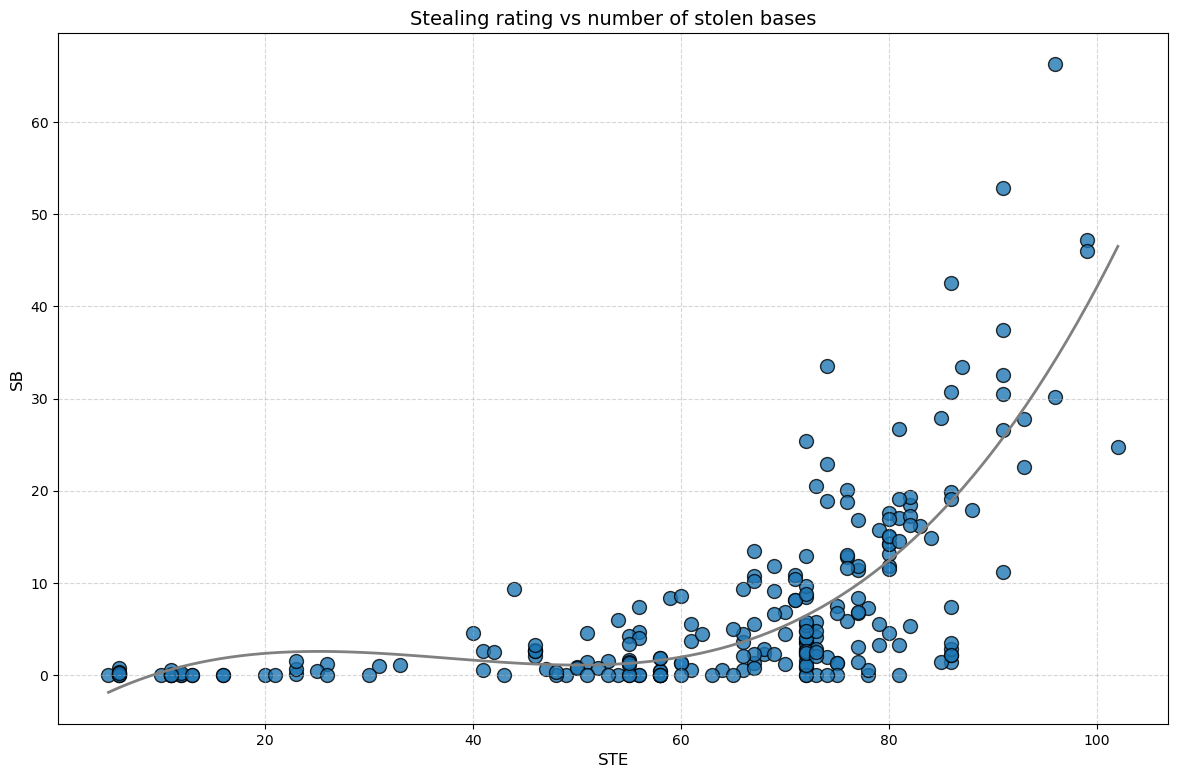

In [33]:
# Stolen bases

# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not excluding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Show the plot
plt.show()


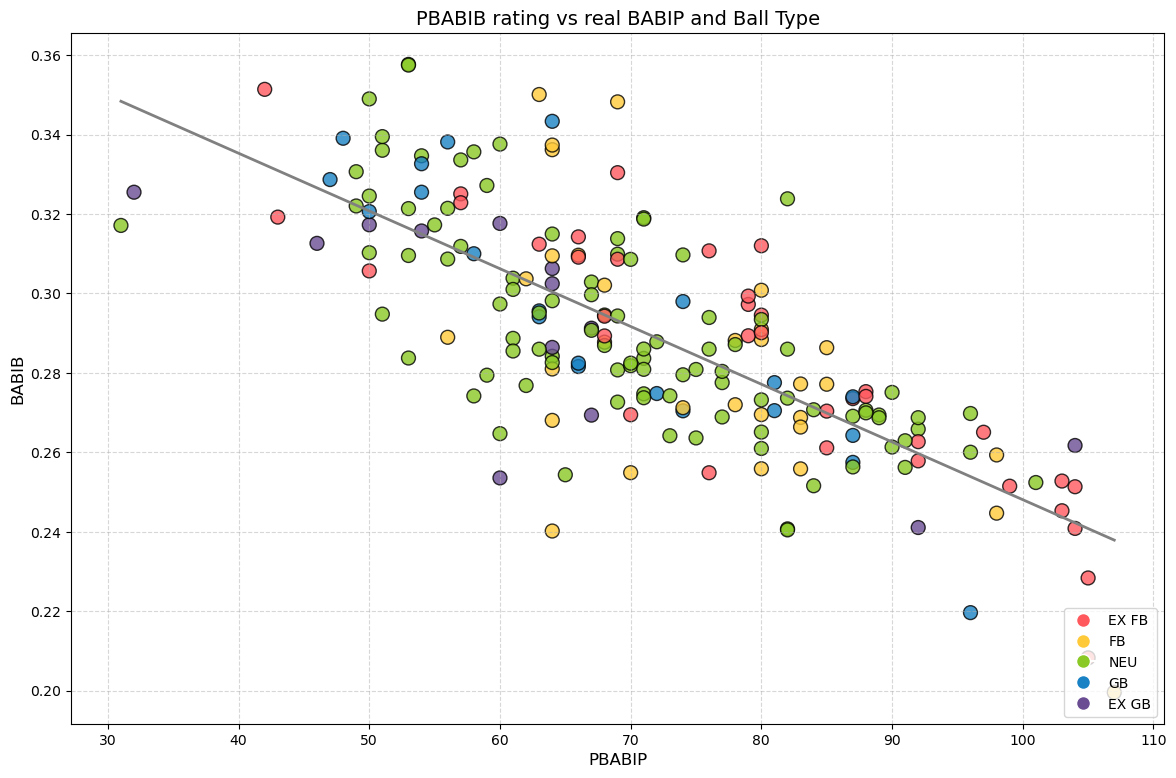

In [34]:
# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}
chart_data = df_pitchers_agg[df_pitchers_agg['IP'] > 100]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot
plt.scatter(chart_data['PBABIP'], chart_data['BABIP'], s=100, c=chart_data['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# # Calculate polynomial fit
# coefficients = np.polyfit(chart_data['BABIP'].astype(float), chart_data['PBABIP'].astype(float), 1)
# polynomial = np.poly1d(coefficients)
# x_values = np.linspace(min(chart_data['BABIP']), max(chart_data['BABIP']), 100)
# y_values = polynomial(x_values)

# from sklearn.linear_model import Ridge

# # Fit a ridge regression model
# ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
# ridge.fit(np.vander(np.nan_to_num(chart_data['BABIP'], nan=0.0), 3), np.nan_to_num(chart_data['PBABIP'], nan=0.0))

# # Generate predicted values using the ridge model
# y_values = ridge.predict(np.vander(x_values, 3))

# Fit linear regression
X = sm.add_constant(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(chart_data['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

# Generate the linear regression line
x_values = np.linspace(min(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

# Set labels and title
plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

# Increase spacing between subplots
plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

# Show the plot
plt.show()


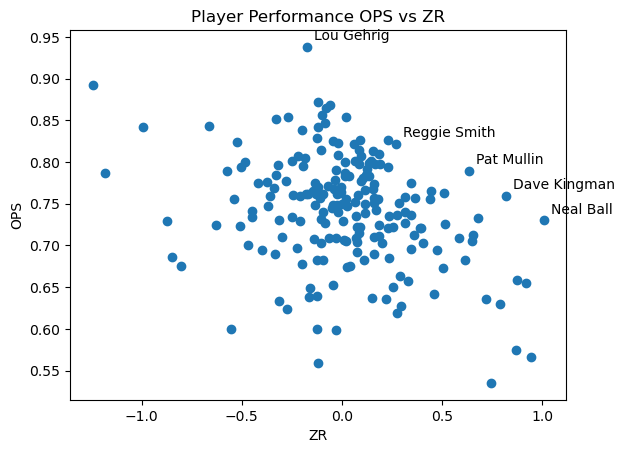

In [35]:
# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[df_batters_agg['PA_WM'] > 300]

# Separate data into x and y coordinates
x = data['ZR']
y = data['OPS']
names = data['Name']


# Create scatter plot
plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

# Set labels and title
plt.xlabel('ZR')
plt.ylabel('OPS')
plt.title('Player Performance OPS vs ZR')

# Display the chart
plt.show()


## Modeling

### Team

In [36]:
# Is more important how many runs team score or prevent opponent to score - offense over defense
# How many runs can be prevented per each position and its rating? - IP weighted average per each position 
    # sensitive to available players (variations teams play)
# How many runs can be added by increasing team's average contact (babip, avoid K's), gap, power, eye? - PA weighted average of ratings
    # issue is that game isn't linear -> the best batter will outperform their stats -> averaging stats across all batters will exclude the natural difference between average, excellent and poor batters

#### Winrate

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [38]:
# Is more important how many runs team score or prevent opponent to score - offense over defense
X = np.asarray(df_team_agg[['AVG_ERA','AVG_R']], dtype=float)
y = np.asarray(df_team_agg['AVG_W'], dtype=float)
w = df_team_agg['W'] + df_team_agg['L']
w = np.asarray(w, dtype=float)

# Fit the weighted least squares model
wregressor = sm.WLS(y, X, weights = w).fit()

# Print the summary of the final model
print(wregressor.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.974
Model:                            WLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          1.275e+04
Date:                Sat, 10 Jun 2023   Prob (F-statistic):                        0.00
Time:                        07:31:01   Log-Likelihood:                          537.55
No. Observations:                 684   AIC:                                     -1071.
Df Residuals:                     682   BIC:                                     -1062.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Defense

In [39]:
# How many runs can be prevented per each position and its rating? - IP weighted average per each position 
df_team_agg['AVG_RA'].fillna(0, inplace=True)
df_team_agg['AVG_RA'].replace({None: 0}, inplace=True)

X = np.asarray(df_team_agg[['AVG_C','AVG_1B','AVG_2B','AVG_3B','AVG_SS','AVG_LF','AVG_CF','AVG_RF']], dtype=float)
X = sm.add_constant(X)
y = np.asarray(df_team_agg['AVG_RA'], dtype=float)
w = df_team_agg['W'] + df_team_agg['L']
w = np.asarray(w, dtype=float)

# Fit the weighted least squares model
wregressor = sm.WLS(y, X, weights = w).fit()

# Print the summary of the final model
print(wregressor.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            WLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     15.15
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           1.51e-20
Time:                        07:31:02   Log-Likelihood:                -916.03
No. Observations:                 684   AIC:                             1850.
Df Residuals:                     675   BIC:                             1891.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8418      0.363     21.623      0.0

#### Offense

In [40]:
# How many runs can be added by increasing team's average contact (babip, avoid K's), gap, power, eye? - PA weighted average of ratings
    # issue is that game isn't linear -> the best batter will outperform their stats -> averaging stats across all batters will exclude the natural difference between average, excellent and poor batters
df_team_agg['AVG_R'].fillna(0, inplace=True)
df_team_agg['AVG_R'].replace({None: 0}, inplace=True)

X = np.asarray(df_team_agg[['AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE',"AVG_KS"]], dtype=float)
y = np.asarray(df_team_agg['AVG_R'], dtype=float)
w = df_team_agg['W'] + df_team_agg['L']
w = np.asarray(w, dtype=float)

# Fit the weighted least squares model
wregressor = sm.WLS(y, X, weights = w).fit()

# Print the summary of the final model
print(wregressor.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.712
Model:                            WLS   Adj. R-squared (uncentered):              0.710
Method:                 Least Squares   F-statistic:                              336.1
Date:                Sat, 10 Jun 2023   Prob (F-statistic):                   6.23e-181
Time:                        07:31:02   Log-Likelihood:                         -1815.1
No. Observations:                 684   AIC:                                      3640.
Df Residuals:                     679   BIC:                                      3663.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Batting

In [41]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 1000]

In [42]:
# size of sample
len(df_batters_agg_model)

101

In [43]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray'
]

#### Correlation

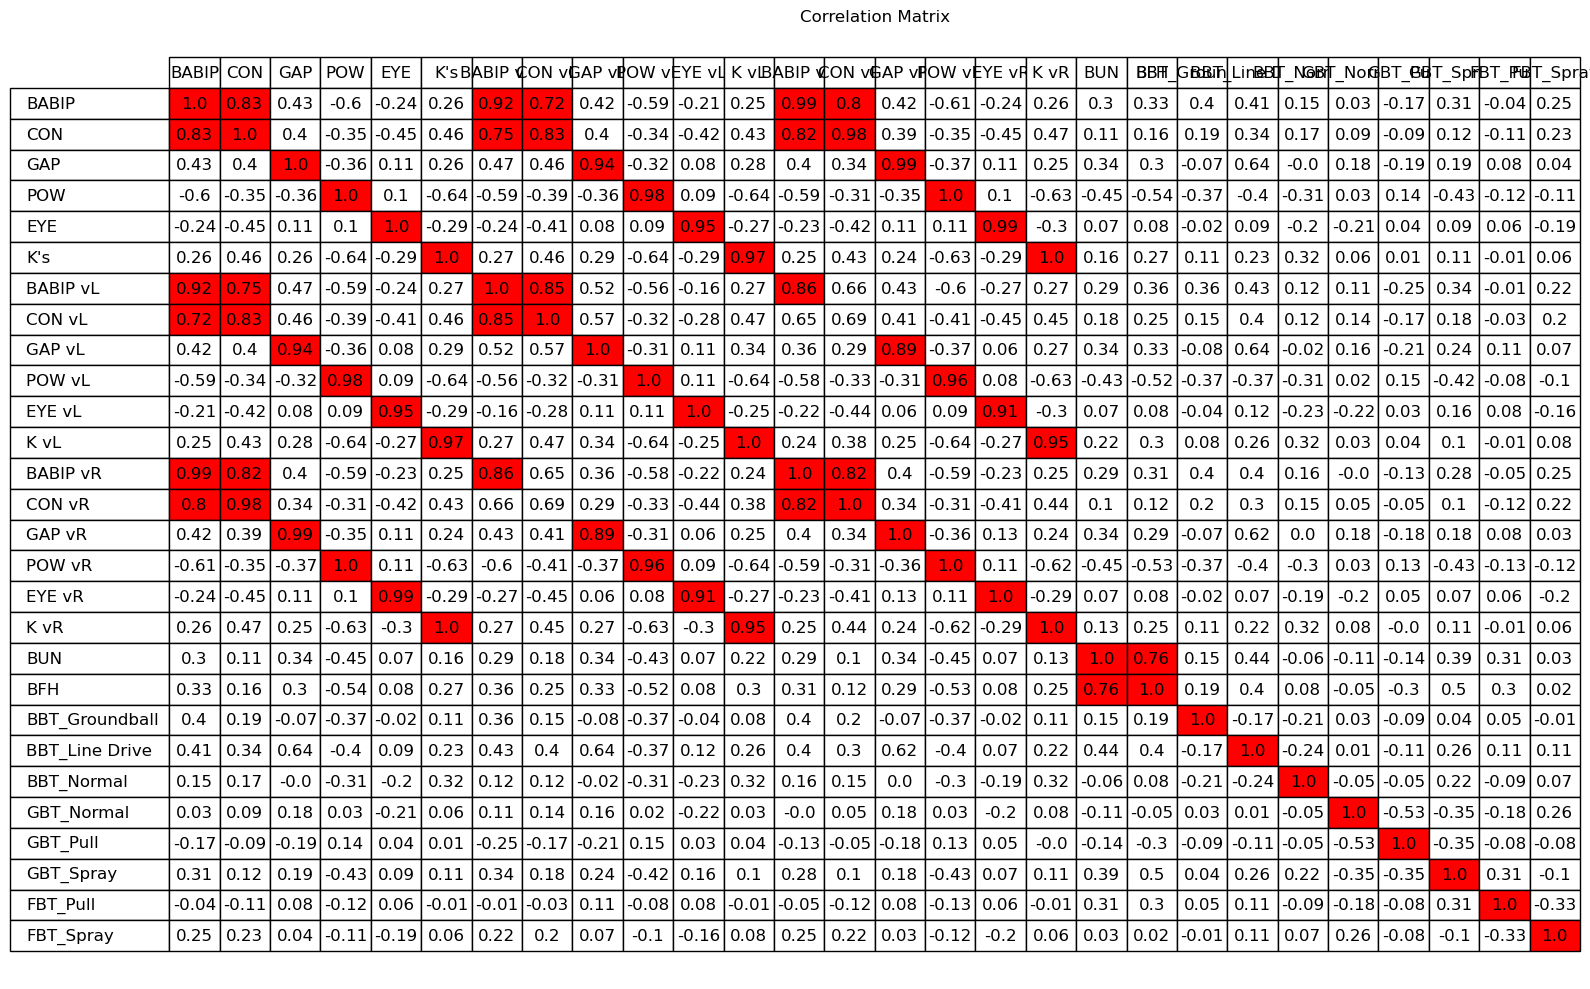

In [44]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Create a table plot
table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

# Set table properties
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Hide axis
ax.axis('off')

# Set plot title
plt.title('Correlation Matrix')

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [46]:
# Example usage
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

# Print the correlated pairs
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - CON: 0.8272102497829416
BABIP - BABIP vL: 0.9225473252015911
BABIP - BABIP vR: 0.9901927848440271
BABIP - CON vR: 0.8021059960590741
CON - CON vL: 0.8264989661537274
CON - BABIP vR: 0.8231394655048575
CON - CON vR: 0.9761196850348887
GAP - GAP vL: 0.9370503380890433
GAP - GAP vR: 0.9919365722426711
POW - POW vL: 0.9764144094740113
POW - POW vR: 0.9977757720406465
EYE - EYE vL: 0.9461426064718208
EYE - EYE vR: 0.9945974785450155
K's - K vL: 0.9710098164401871
K's - K vR: 0.9973016739162317
BABIP vL - CON vL: 0.8457081795275653
BABIP vL - BABIP vR: 0.8603646302348278
GAP vL - GAP vR: 0.8864618152969207
POW vL - POW vR: 0.9602405036271137
EYE vL - EYE vR: 0.9078273591338964
K vL - K vR: 0.9518056571774086
BABIP vR - CON vR: 0.8237683254499181


In [47]:
# Removal of correlated predictors
for element in ['BABIP vL', 'BABIP vR','CON','GAP vL','GAP vR','EYE vL','EYE vR','CON vL','CON vR','POW vL','POW vR','K vL','K vR']:
    predictors_batters.remove(element)

<Axes: >

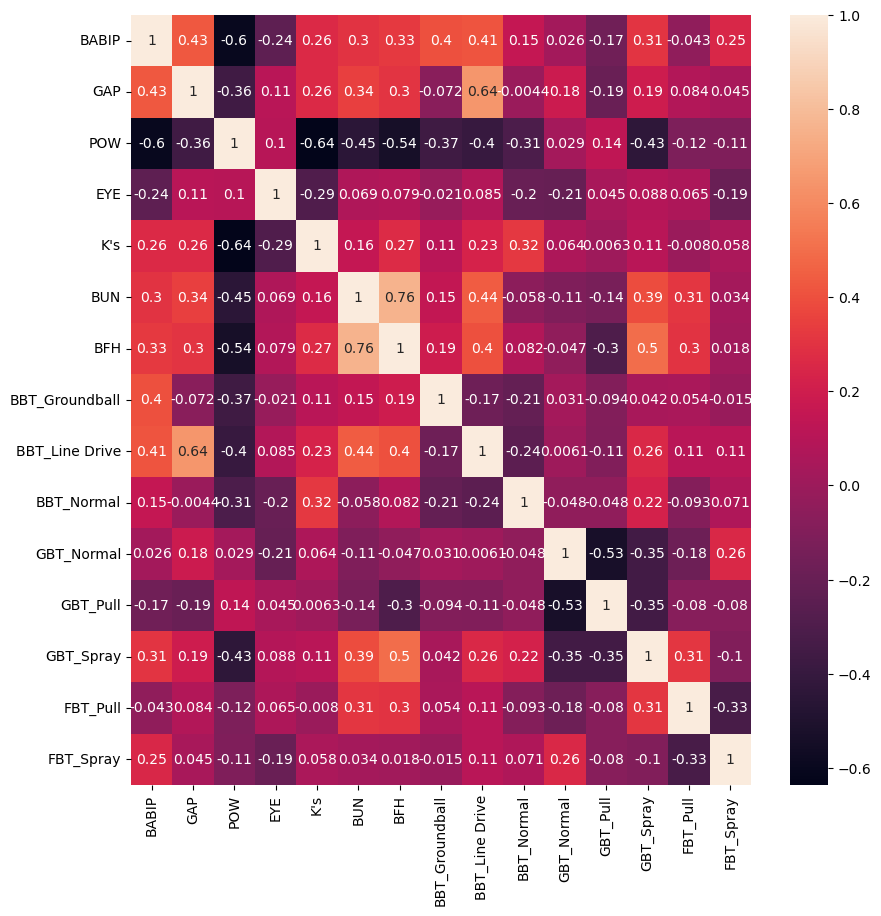

In [48]:
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 5 is fine

           feature        VIF
0            BABIP  34.436303
1              GAP  38.990393
2              POW  13.780498
3              EYE  12.463972
4              K's  13.185257
5              BUN   5.635002
6              BFH   6.429991
7   BBT_Groundball   3.830373
8   BBT_Line Drive   5.137088
9       BBT_Normal   3.673553
10      GBT_Normal   4.499343
11        GBT_Pull   4.088494
12       GBT_Spray   3.512240
13        FBT_Pull   1.792400
14       FBT_Spray   1.771669


In [50]:
# predictors and a target variable
X = np.asarray(df_batters_agg_model[predictors_batters].values, dtype=float)
y = np.asarray(df_batters_agg_model['OPS'].values, dtype=float)

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
print("Size of train sample: " + str(len(X_train)))
print("Size of test sample: " + str(len(X_test)))

Size of train sample: 80
Size of test sample: 21


#### Backward OLS elimination

In [52]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [53]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test)

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     38.58
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           6.41e-22
Time:                        07:31:24   Log-Likelihood:                 175.65
No. Observations:                  80   AIC:                            -335.3
Df Residuals:                      72   BIC:                            -316.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2800      0.040      7.013      0.0

In [54]:
# notes: Kurtosis: 3.282 -> distribution is too peaked

In [55]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [56]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.01539
The R2 score is 73.02%


In [57]:
# Sample is extremely small -> cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
scores = cross_val_score(LinearRegression(), X_train[:, column_positions], y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.14389825 0.68784784 0.76902831 0.87358212 0.53415657]
Mean score: 0.6017026175856973


#### Lasso

In [58]:
from sklearn.linear_model import Lasso

pred_names = predictors_batters.copy()

# Lasso regression
lasso = Lasso(alpha=0.01)  
            # Set the regularization parameter alpha
            # any real-valued number between zero and infinity; the larger the value, the more aggressive the penalization is.
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Print the coefficients
print("Lasso Coefficients:")
for feature, coef in zip(pred_names, lasso.coef_):
    if coef != 0.00000000: print(f"{feature}: {coef:.4f}") # Print out only non-zero coefs

# Print the mean squared errors
print(f"\nLasso MSE: {lasso_mse:.4f}")

train_r2 = r2_score(y_true=y_test, y_pred=lasso_predictions)
print ("The R2 score is {:.2f}%".format(train_r2*100))


# Cross-validation
scores = cross_val_score(lasso, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


## Ridge regression shrinks all regression coefficients towards zero

Lasso Coefficients:
BABIP: 0.0021
GAP: 0.0013
POW: 0.0023
EYE: 0.0007
K's: 0.0007
BFH: 0.0000

Lasso MSE: 0.0007
The R2 score is 74.15%

Cross-validation scores: [0.18709878 0.69936486 0.73412663 0.85386861 0.54586328]
Mean score: 0.6040644305916627


#### XGBoost

In [59]:
import xgboost as xgb

# XGBRFRegressor (random forest)
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.02319
The R2 score is 39.31%


In [60]:
# Cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [-0.12354422  0.50273445  0.50172971  0.54755232  0.53098105]
Mean score: 0.3918906621204431


In [61]:
# # XGB Cross-validation 2
# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
# params = {'objective':'reg:squarederror'}
# xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=42) 

# xgb_cv

In [62]:
# Best model search
# from sklearn.model_selection import GridSearchCV

# best_xgb = GridSearchCV(
#     xgb_model, param_grid={}, cv=10, verbose=0, n_jobs=-1)

# scores = cross_val_score(best_xgb, X_train, y_train, scoring='r2')
# scores

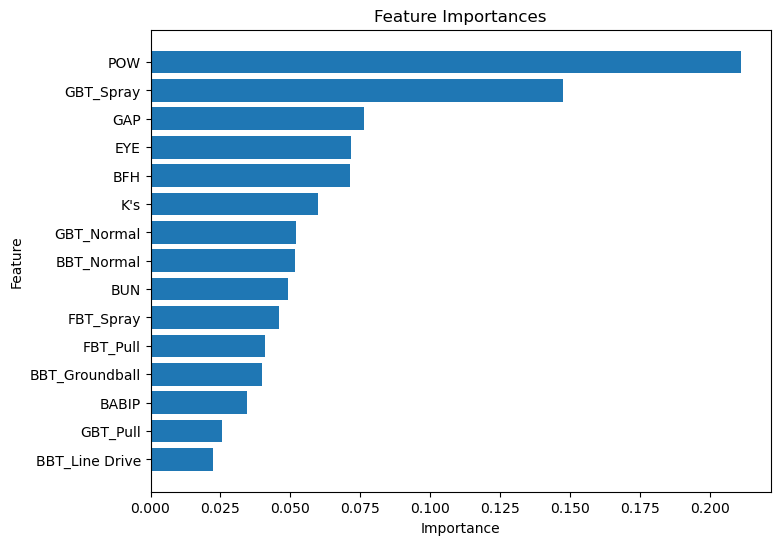

In [63]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': pred_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### Prediction

In [64]:
# Predict OPS
# categorical predictors into numerical
df_batters_agg = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

df_batters_agg['ops_pred'] = lasso.predict(df_batters_agg[predictors_batters])
df_batters_agg.sort_values('ops_pred', ascending = False)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


,POS,Name,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM,BBT_Groundball,BBT_Line Drive,BBT_Normal,GBT_Normal,GBT_Pull,GBT_Spray,FBT_Pull,FBT_Spray,ops_pred
473,DH,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,0,60,0,0,0,0,0,0,59,0,88,91,89,132.792279,132.792279,58.448718,514.367186,150.076771,93.41961,39.921035,5.593332,11.142794,85.654749,75.67449,74.007458,11.955556,0.504497,2.12766,0.0,8.159684,1.338013,96.68787,17.746154,13.511735,56.657162,234.612854,0.266526,0.353201,0.395976,8.943162,5.42735,0.129192,0.339303,0.749177,95.25641,0.319346,0.883527,82.145207,95.805556,13.64773,1.980698,3.805897,32.507129,16.648388,61.207265,13.64773,0.987059,0.232507,0.921255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,100.0,468,0.0,0,1,0,1,0,0,0,1,0.837740
415,CF,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,59,60,0,0,0,0,0,0,59,0,88,91,89,135.657725,127.205563,60.468516,530.530103,160.473903,103.103442,37.932871,2.898468,16.539121,81.208218,87.229319,60.475379,9.824164,2.770374,3.348842,0.0,5.50123,0.144446,113.605791,19.156664,10.611365,57.370461,253.821075,0.296256,0.367067,0.47084,9.93638,7.007574,0.174602,0.371787,0.83792,119.679942,0.346926,2.806963,85.903409,118.975623,17.409888,3.36935,3.764273,26.576108,13.120101,54.703083,17.409888,1.016031,2.098153,3.151522,82.149164,78.701526,285.643587,7.040403,273.332932,5.270252,2.636148,0.0,0.720025,2.690586,-0.199471,0.719262,0.089938,0.03543,0.178535,71.655291,0.0,0.0,0.0,71.621431,485.60683,476.167115,54.686232,87.605081,69.14939,28.157907,58.000478,27.609845,12.92781,36.033818,8.012956,7.090627,65.322617,8.47246,76.122362,0.00192,0.119009,97.949942,14563,17442.2,0,1,0,1,0,0,0,1,0.837740
541,LF,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,0,60,0,0,0,0,0,0,59,0,88,91,89,134.972005,130.969305,63.75443,520.327205,177.500695,121.248461,37.620617,2.287257,16.344359,92.991304,93.515467,75.8607,11.626076,2.692292,0.0,0.0,3.812095,0.0,125.251161,22.022532,6.504388,56.252234,268.728904,0.324484,0.397585,0.494835,13.451392,8.626076,0.170499,0.395734,0.892377,131.870886,0.395987,3.862367,105.166184,133.222785,35.111782,4.77465,4.007823,52.868999,19.417861,67.84481,35.111782,4.974785,0.848191,5.87301,139.522694,130.969305,313.973712,8.791645,302.489775,2.692292,4.288607,0.0,0.994851,2.476532,-1.244051,0.947405,0.0,0.0,0.0,121.837975,0.0,0.0,0.0,95.954684,226.693932,214.514708,57.645063,42.229589,27.170685,28.360506,25.369012,5.613769,15.65038,35.424339,6.693917,20.78481,28.590185,5.947769,44.557954,0.0,3.524556,83.860759,395,766.7,0,1,0,1,0,0,0,1,0.837740
707,RP,Jimmy Ryan,TRN,"5' 9""",Right,Left,59,84,84,83,67,63,52,85,86,84,68,64,52,84,84,82,66,62,52,6,2,0,0,28,23,25,24,73,56,80,60,60,0,0,0,0,0,0,59,0,88,91,89,136.78538,130.019916,60.155039,523.745314,167.386364,103.899953,41.32732,2.67104,19.488051,91.553421,89.996485,66.041471,10.741402,3.567245,4.589972,0.0,5.623243,0.0,109.017104,18.674419,10.663074,63.48641,272.519916,0.305851,0.382385,0.48992,11.11945,7.485694,0.18401,0.385709,0.872303,128.493305,0.355672,3.64952,98.231022,128.317477,29.407451,4.436739,3.757583,30.456888,16.644799,51.847393,

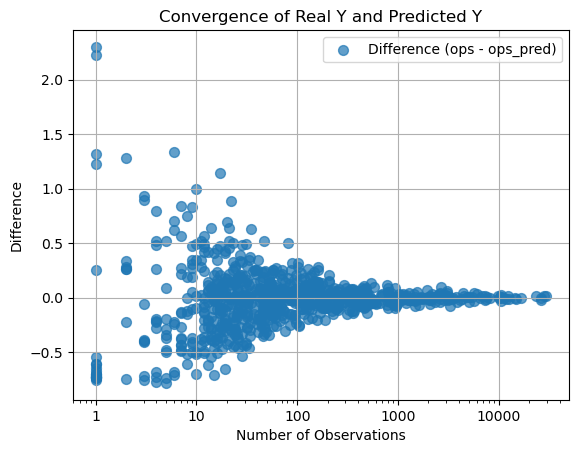

In [65]:
from matplotlib.ticker import ScalarFormatter

def plot_convergence(observations, ops, ops_pred):
    differences = np.array(ops) - np.array(ops_pred)

    plt.scatter(observations, differences, s=50, alpha=0.7, label='Difference (ops - ops_pred)')

    plt.xlabel('Number of Observations')
    plt.ylabel('Difference')
    plt.title('Convergence of Real Y and Predicted Y')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set logarithmic scale for the x-axis
    #plt.xlim(1, 10000)  # Set x-axis limits
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.show()


plot_convergence( df_batters_agg['PA_WM'], df_batters_agg['OPS'], df_batters_agg['ops_pred'])


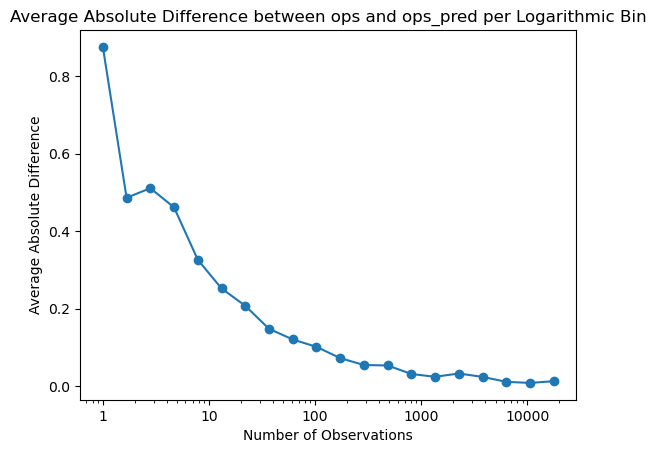

In [66]:
observations = df_batters_agg['PA_WM']
ops = df_batters_agg['OPS']
ops_pred = df_batters_agg['ops_pred']

# Calculate the absolute differences between ops and ops_pred
differences = np.abs(np.array(ops) - np.array(ops_pred))

# Calculate the logarithmic bins
log_bins = np.logspace(np.log10(1), np.log10(max(observations)),num=21)

# Calculate the bin indices for each observation
bin_indices = np.digitize(observations, log_bins)

# Calculate the average absolute differences for each bin
bin_averages = [np.mean(differences[bin_indices == i]) for i in range(1, len(log_bins))]


fig, ax = plt.subplots()
ax.plot(log_bins[:-1], bin_averages, 'o-')

ax.set_xscale('log')
ax.set_xlabel('Number of Observations')
ax.set_ylabel('Average Absolute Difference')
ax.set_title('Average Absolute Difference between ops and ops_pred per Logarithmic Bin')

# Set full number format for x-axis ticks
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()